#### *CSC 180  Intelligent Systems (Spring 2021)*

#### *Dr. Haiquan Chen, Dept of Computer Scicence*

#### *California State University, Sacramento*
<hr>

## Project 2: Network Intrusion Detection System
### **Team Members:** Quinn Roemer, Logan Hollmer

#### **Description:**
In this project we were tasked with creating fully connected neural networks and convolutional neural networks to predict whether a network intrusion was from an authorized user or not. The dataset used for this problem is called ``KDD CUP 99`` and includes the necessary features to predict whether a network signature is valid or not. This dataset contains information on 22 different attack types. However, for the purpose of this project we focused on determining whether a network connection is safe. Thus turning the problem into binary classification.

#### **Step 1:** Load imports and Provided Functions
To enable us to more quickly write code, we used the function provideds **Dr. Haiquan Chen**.

In [5]:
#Import all the required libraries to run our project.

from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from sklearn.linear_model import Ridge
from collections.abc import Sequence
from sklearn import preprocessing
from sklearn import svm, datasets
from sklearn import metrics
from numpy import random

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras
import time

%matplotlib inline

In [7]:
#Import Dr.Haiquan Chen's "little gems"

#Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

#Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
#Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_
#Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    #find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    #Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        #Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        #Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

#Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

#Plot a confusion matrix.
#cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def report_coef(names,coef):
    r = pd.DataFrame( { 'coef': coef, 'positive': coef>=0  }, index = names )
    r = r.sort_values(by=['coef'])
    display(r)
    r['coef'].plot(kind='barh', color=r['positive'].map({True: 'b', False: 'r'}))  
    temp=r['coef'].copy().abs()
    temp = temp.sort_values(ascending=False)
    print("Top 30 most important features")
    display(temp[0:30])

#### **Step 2**: Import data and Perform Pre-processing
The dataset used, <a href="http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html">KDD CUP 99</a> was already in CSV form. This made it easy to load it up into a Pandas Dataframe.<br><br>

**Note:** We made models using the 10% dataset and the full dataset. The code below used the full dataset.

In [9]:
#Load data in (From Google Drive)
#Note: Originally on Google Collab, so such an operation worked.
data = pd.read_csv('/content/drive/MyDrive/csc 180/Project 2/kddcup.data.corrected.csv', header=None)

#Columns to add to the data
data.columns = ['duration',
              'protocol_type',
              'service',
              'flag',
              'src_bytes',
              'dst_bytes',
              'land','wrong_fragment',
              'urgent','hot',
              'num_failed_logins',
              'logged_in',
              'num_compromised',
              'root_shell',
              'su_attempted',
              'num_root',
              'num_file_creations',
              'num_shells',
              'num_access_files',
              'num_outbound_cmds',
              'is_host_login',
              'is_guest_login',
              'count','srv_count',
              'serror_rate',
              'srv_serror_rate',
              'rerror_rate',
              'srv_rerror_rate',
              'same_srv_rate',
              'diff_srv_rate',
              'srv_diff_host_rate',
              'dst_host_count',
              'dst_host_srv_count',
              'dst_host_same_srv_rate',
              'dst_host_diff_srv_rate',
              'dst_host_same_src_port_rate',
              'dst_host_srv_diff_host_rate',
              'dst_host_serror_rate',
              'dst_host_srv_serror_rate',
              'dst_host_rerror_rate',
              'dst_host_srv_rerror_rate',
              'outcome']

In [10]:
#Remove null values from the dataset
print(data.isnull().values.any())

False


In [11]:
#Remove duplicates from the dataset
#Note: A huge proportion (~4/5 of the data is duplicates). Such an operation prevents a skewed model
data=data.drop_duplicates(ignore_index=True)

In [12]:
#Label encode the 'outcome' column into 0 (normal) and 1 (attack)
data['outcome'] = (data['outcome'] != 'normal.').astype(int)

In [13]:
label_outcomes=data['outcome'].copy().to_numpy()

In [14]:
#Rename the column 'count' (count is a function in pandas and referencing a column by this name can cause errors)
data=data.rename(columns={"count": "num_count"})

In [15]:
#Check for unique values in columns to see if normalization is needed
print("duration: ",data.duration.unique())
print("protocol_type: ",data.protocol_type.unique())
print("service: ",data.service.unique())
print("flag: ",data.flag.unique())
print("src_bytes: ",data.src_bytes.unique())
print("dst_bytes: ",data.dst_bytes.unique())
print("land: ",data.land.unique())
print("wrong_fragment: ",data.wrong_fragment.unique())
print("urgent: ",data.urgent.unique())
print("hot: ",data.hot.unique())
print("num_failed_logins: ",data.num_failed_logins.unique())
print("logged_in: ",data.logged_in.unique())
print("num_compromised: ",data.num_compromised.unique())
print("root_shell: ",data.root_shell.unique())
print("su_attempted: ",data.su_attempted.unique())
print("num_root: ",data.num_root.unique())
print("num_file_creations: ",data.num_file_creations.unique())
print("num_shells: ",data.num_shells.unique())
print("num_access_files: ",data.num_access_files.unique())
print("num_outbound_cmds: ",data.num_outbound_cmds.unique())
print("is_host_login: ",data.is_host_login.unique())
print("is_guest_login: ",data.is_guest_login.unique())
print("num_count: ",data.num_count.unique())
print("srv_count: ",data.srv_count.unique())
print("serror_rate: ",data.serror_rate.unique())
print("srv_serror_rate: ",data.srv_serror_rate.unique())
print("rerror_rate: ",data.rerror_rate.unique())
print("srv_rerror_rate: ",data.srv_rerror_rate.unique())
print("same_srv_rate: ",data.same_srv_rate.unique())
print("diff_srv_rate: ",data.diff_srv_rate.unique())
print("srv_diff_host_rate: ",data.srv_diff_host_rate.unique())
print("dst_host_count: ",data.dst_host_count.unique())
print("dst_host_srv_count: ",data.dst_host_srv_count.unique())
print("dst_host_same_srv_rate: ",data.dst_host_same_srv_rate.unique())
print("dst_host_diff_srv_rate: ",data.dst_host_diff_srv_rate.unique())
print("dst_host_same_src_port_rate: ",data.dst_host_same_src_port_rate.unique())
print("dst_host_srv_diff_host_rate: ",data.dst_host_srv_diff_host_rate.unique())
print("dst_host_serror_rate: ",data.dst_host_serror_rate.unique())
print("dst_host_srv_serror_rate: ",data.dst_host_srv_serror_rate.unique())
print("dst_host_rerror_rate: ",data.dst_host_rerror_rate.unique())
print("dst_host_srv_rerror_rate: ",data.dst_host_srv_rerror_rate.unique())

duration:  [   0   22   60 ... 2906 2911 2966]
protocol_type:  ['tcp' 'udp' 'icmp']
service:  ['http' 'smtp' 'domain_u' 'auth' 'finger' 'telnet' 'eco_i' 'ftp' 'ntp_u'
 'ecr_i' 'other' 'urp_i' 'private' 'pop_3' 'ftp_data' 'netstat' 'daytime'
 'ssh' 'echo' 'time' 'name' 'whois' 'domain' 'mtp' 'gopher' 'remote_job'
 'rje' 'ctf' 'supdup' 'link' 'systat' 'discard' 'X11' 'shell' 'login'
 'imap4' 'nntp' 'uucp' 'pm_dump' 'IRC' 'Z39_50' 'netbios_dgm' 'ldap'
 'sunrpc' 'courier' 'exec' 'bgp' 'csnet_ns' 'http_443' 'klogin' 'printer'
 'netbios_ssn' 'pop_2' 'nnsp' 'efs' 'hostnames' 'uucp_path' 'sql_net'
 'vmnet' 'iso_tsap' 'netbios_ns' 'kshell' 'urh_i' 'http_2784' 'harvest'
 'aol' 'tftp_u' 'http_8001' 'tim_i' 'red_i']
flag:  ['SF' 'S2' 'S1' 'S3' 'OTH' 'REJ' 'RSTO' 'S0' 'RSTR' 'RSTOS0' 'SH']
src_bytes:  [ 215  162  236 ... 4082 5159 3667]
dst_bytes:  [45076  4528  1228 ... 13828 14180 15808]
land:  [0 1]
wrong_fragment:  [0 1 3]
urgent:  [ 0  1  5  2  3 14]
hot:  [ 0  1  3  4 18 30 22 19 11  5 17 15 

#### **Step 2.5:** Encode/Normalize Features
There are several values that need to be one hot encoded (OHE) due to the non-ordinal nature of the data. Descriptions of all the columns can be found <a href="http://kdd.ics.uci.edu/databases/kddcup99/task.html">here</a>. The columns that need OHE are the ``protocol_type``, ``flag``, and ``service``. Some of the data followed a log distribution, on these we ran log normalization. The columns specifically are ``srv_count``, ``num_count``, and ``duration``. The rest of the numerical columns were encoded between the range 0, 1. Please refer to the code below for the exact column names.

In [16]:
#Encode categorical columns with OHE
encode_text_dummy(data, 'protocol_type')
encode_text_dummy(data, 'service')
encode_text_dummy(data, 'flag')

In [17]:
#Encode columns with logarithmic distribution
data['srv_count'] = np.log(data['srv_count']+1)
data['num_count'] = np.log(data['num_count']+1)
data['duration'] = np.log(data['duration']+1)

In [18]:
#Normalize other numerical columns with the provided encode_numeric_range() function
encode_numeric_range(data, 'duration')
encode_numeric_range(data, 'src_bytes')
encode_numeric_range(data, 'dst_bytes')
encode_numeric_range(data, 'wrong_fragment')
encode_numeric_range(data, 'urgent')
encode_numeric_range(data, 'hot')
encode_numeric_range(data, 'num_failed_logins')
encode_numeric_range(data, 'num_compromised')
encode_numeric_range(data, 'num_root')
encode_numeric_range(data, 'num_file_creations')
encode_numeric_range(data, 'num_shells')
encode_numeric_range(data, 'num_access_files')
encode_numeric_range(data, 'num_count')
encode_numeric_range(data, 'srv_count')
encode_numeric_range(data, 'serror_rate')
encode_numeric_range(data, 'srv_serror_rate')
encode_numeric_range(data, 'rerror_rate')
encode_numeric_range(data, 'srv_rerror_rate')
encode_numeric_range(data, 'same_srv_rate')
encode_numeric_range(data, 'diff_srv_rate')
encode_numeric_range(data, 'srv_diff_host_rate')
encode_numeric_range(data, 'dst_host_count')
encode_numeric_range(data, 'dst_host_srv_count')
encode_numeric_range(data, 'dst_host_same_srv_rate')
encode_numeric_range(data, 'dst_host_diff_srv_rate')
encode_numeric_range(data, 'dst_host_same_src_port_rate')
encode_numeric_range(data, 'dst_host_srv_diff_host_rate')
encode_numeric_range(data, 'dst_host_serror_rate')
encode_numeric_range(data, 'dst_host_srv_serror_rate')
encode_numeric_range(data, 'dst_host_rerror_rate')
encode_numeric_range(data, 'dst_host_srv_rerror_rate')

In [19]:
#Delete num_outbound_cmds since it is always 0
data=data.drop(columns=['num_outbound_cmds'])

In [20]:
#Check to see if any null values are in the data
print(data.isnull().values.any())

False


#### **Step 3:** Builder Functions for our Training Scripts
After performing the necessary steps to prepare our data, we are ready to begin training our models. To do this we tried various approaches varying the activation functions ``['relu', 'sigmoid', 'tanh']``, number of hidden layers (0-4) and neuroun counts (2^5 - 2^8) for each layer. In addition, the optimizer was chosen. These changes were automated using the below scripts. Each model was run 5 times to help prevent finding local optimum.
<br>
<br>
**Note:** Three builder functions were created. One builds a standard fully connected neural network based on a passed seed (randomizes creation), another allows a specific model to be built, and the last builds a specific fully connected neural network with regularization.

In [21]:
#Returns a random activation function
def activation_function():
  return random.choice(['relu', 'sigmoid', 'tanh'])


#Builds a random model based off a seed
#The seed allows me to recreate the same model when passing the same seed.
def build_model_random(seed):
  np.random.seed(seed) 
  model = Sequential()
  number_of_layers=random.randint(4)
  number_of_neurons=pow(2,random.randint(5,8))

  #Choose activation function for all layers in model
  activ=activation=activation_function()
  
  #Add input layer
  model.add(Dense(number_of_neurons, input_dim=x.shape[1], activation=activ))
  
  #Add hidden layers
  for i in range(number_of_layers):
    number_of_neurons=pow(2,random.randint(number_of_layers-i)+2)
    
    model.add(Dense(number_of_neurons, activation=activ))

  #Add last layer, compile, and return the model
  model.add(Dense(y.shape[1], activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer=random.choice(['adam', 'sgd']))
  return model


#This function allows me to build a specific model by defining the number of layer
#Note: Layers are built with a decreasing number of neuron counts.
def custom_model(layers, activ, opt):
  model = Sequential()

  #Add input layer
  model.add(Dense(pow(2,(layers)), input_dim=x.shape[1], activation=activ))
  
  #Add hidden layers
  for i in range(layers-2):
    number_of_neurons=pow(2,(layers-1-i))    
    model.add(Dense(number_of_neurons, activation=activ))

  #Add output layer, compile, and return the model
  model.add(Dense(y.shape[1], activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer=opt)
  return model

#Creates a specific model with regularization.
def custom_model_reg(layers, activ, opt):
  model = Sequential()

  #Add input layer
  model.add(Dense(pow(2,(layers)), input_dim=x.shape[1], activation=activ))
  
  #Add hidden layers
  for i in range(layers-2):
    number_of_neurons=pow(2,(layers-1-i))    
    model.add(Dense(number_of_neurons, activation=activ))

  #Add output layer with regularizers, compile, and return the model
  model.add(Dense(y.shape[1], kernel_regularizer=regularizers.l1(0.01), 
                activity_regularizer=regularizers.l2(0.01), activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer=opt)
  return model

#### **Step 3.5:** Training our Fully Connected Neural Networks
One of the requirements for this project is performing a train/test split and using a monitor to prevent overfitting. These both can be found in the code below.
<br>
<br>
The below script was used to automate the training process for our fully connected neural networks. In the code below, 10 different fully connected models were trained. Each model was ran 5 times to ensure we were not hitting a local optimum.

In [23]:
outcome=encode_text_index(data,'outcome')

# Create x & y for training and testing
x, y = to_xy(data,'outcome')
    
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42) 

In [1]:
#Model callbacks
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=4, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True)
i=1

#Train 10 models
while (i<10):
  np.random.seed()
  seed=np.random.randint(1000000000)
  i+=1
  k=0

  #Train each model 5 times to prevent local optimum
  while (k<5):
    k+=1
    model=build_model_random()

    #Save the model
    if (k==1):
      model.save_weights('dnn/best_weights.hdf5')

    #Print model info and train
    print("=========== Model: "+str(i)+"."+str(k)+ " seed:"+str(seed)+" ===============")
    print(model.summary())
    model.fit(x_train,y_train, validation_data=(x_test,y_test),callbacks=[monitor, checkpointer],verbose=2,epochs=1000)
  
  #Check best score
  model.load_weights('dnn/best_weights.hdf5') # load weights from best model

  # Measure accuracy
  pred = model.predict(x_test)
  pred = np.argmax(pred,axis=1)
  y_true = np.argmax(y_test,axis=1)

  #Save the model
  score = metrics.accuracy_score(y_true, pred)
  model.save('/content/drive/MyDrive/csc 180/Project 2/models/'+str(score))
  print("model saved, Accuracy: ",score)

NameError: name 'EarlyStopping' is not defined

### **Training Results:** <br>
The fully connected neural networks performed very well. Due to the shorter training time (when compared to the CNN models) we were able to train several different architectures. You can find the top models trained below. <br><br>

 **Model 1** <br>
 This model had an accuracy of 0.999416 and an average F1 score of 0.999416
 ```
 Classification Report from Keras
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    203288
           1       1.00      1.00      1.00     65460

    accuracy                           1.00    268748
   macro avg       1.00      1.00      1.00    268748
weighted avg       1.00      1.00      1.00    268748
 ```
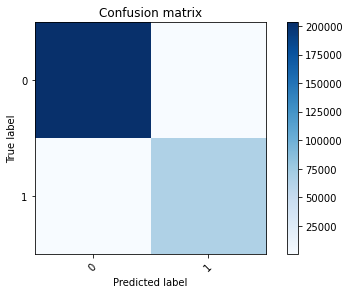
```
Confusion Matrix Values
[[203240     48]
 [   109  65351]]
 ```
 The above models architecture is below. Note that this model used the Relu activaction function and the SGD optimizer.
 ```
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
dense_48 (Dense)             (None, 64)                7808      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_50 (Dense)             (None, 2)                 34        
=================================================================
```



**Model 2** <br>
The second best model had an accuracy of 0.999412 and a average F1 score of 0.999412.
```

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    203288
           1       1.00      1.00      1.00     65460

    accuracy                           1.00    268748
   macro avg       1.00      1.00      1.00    268748
weighted avg       1.00      1.00      1.00    268748
```
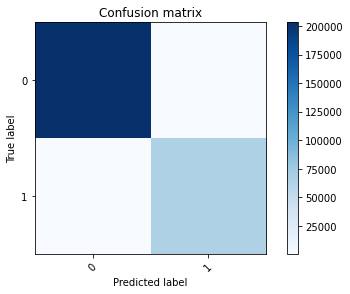

```
Confusion Matrix values
[[203224     64]
 [    94  65366]]
```
The above model's architecture is below. Note that this model used the Tanh activaction function and the SGD optimizer.

```
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
dense_27 (Dense)             (None, 32)                3904      
_________________________________________________________________
dense_28 (Dense)             (None, 4)                 132       
_________________________________________________________________
dense_29 (Dense)             (None, 2)                 10        
=================================================================
```




#### **Step 3.6:** Training our Fully Connected Neural Networks with Regularization
Next we built a set of models using regularization. The custom model function was used with us adjusting the number of layers, optimizer, and activation functions by hand. Below you can see a function that will build 5 models ranging from 1-5 layers using the Relu activation function and the SGD optimizer.

In [184]:
#Model callbacks
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True)
i=3

#Build 5 models
while (i<5):
  np.random.seed()
  seed=np.random.randint(1000000000)
  i+=1
  k=0

  #Model a model, and train it.
  while (k<1):
    k+=1
    model = Sequential()
    model.add(Dense(64, input_dim=x.shape[1], activation='relu'))

    #Add a dropout layer to help prevent overfitting.
    model.add(Dropout(0.1))

    model.add(Dense(32, activation='relu'))

    #Add output layer 
    model.add(Dense(y.shape[1], kernel_regularizer=regularizers.l1(0.01), 
                  activity_regularizer=regularizers.l2(0.01), activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    #Save the models weights
    if (k==1):
      model.save_weights('dnn/best_weights.hdf5')

    #Print model info and train
    print("=========== Model: "+str(i)+"."+str(k)+ " seed:"+str(seed)+" ===============")
    print(model.summary())
    model.fit(x_train,y_train, validation_data=(x_test,y_test),callbacks=[monitor, checkpointer],verbose=2,epochs=1000)
  
  #Load weights from the best model
  model.load_weights('dnn/best_weights.hdf5')

  #Check the score
  pred = model.predict(x_test)
  pred = np.argmax(pred,axis=1)
  y_true = np.argmax(y_test,axis=1)
  score = metrics.accuracy_score(y_true, pred)

  #Save the model
  model.save('gs://project_2_reg/project 2/models/reg2_'+str(score))
  print("model saved, Accuracy: ",score)

=========== Model: 4.1 seed:759601879 ===============
Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_128 (Dense)            (None, 64)                7808      
_________________________________________________________________
dropout_29 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_129 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_130 (Dense)            (None, 2)                 66        
Total params: 9,954
Trainable params: 9,954
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
25196/25196 - 31s - loss: 0.0281 - val_loss: 0.0204
Epoch 2/1000
25196/25196 - 29s - loss: 0.0200 - val_loss: 0.0186
Epoch 3/1000
25196/25196 - 29s - loss: 0.0187 - val_loss: 0.

INFO:tensorflow:Assets written to: gs://project_2_reg/project 2/models/reg2_0.9986790599371902/assets


model saved, Accuracy:  0.9986790599371902
=========== Model: 5.1 seed:49974996 ===============
Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_131 (Dense)            (None, 64)                7808      
_________________________________________________________________
dropout_30 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_132 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_133 (Dense)            (None, 2)                 66        
Total params: 9,954
Trainable params: 9,954
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
25196/25196 - 30s - loss: 0.0287 - val_loss: 0.0216
Epoch 2/1000
25196/25196 - 28s - loss: 0.0201 - val_loss: 0.0189
Epoch 3/1000
25196

INFO:tensorflow:Assets written to: gs://project_2_reg/project 2/models/reg2_0.2437004182356706/assets


model saved, Accuracy:  0.2437004182356706


### **Training Results:** <br>
The fully connected neural networks with regularization performed decently but not as well as the previous fully connected networks.<br><br>

 **Model 1** <br>
 This model had an accuracy of 0.99868 and an average F1 score of 0.99868
 ```
Classification Report from Keras
precision    recall  f1-score   support

           0       1.00      1.00      1.00    203288
           1       1.00      1.00      1.00     65460

    accuracy                           1.00    268748
   macro avg       1.00      1.00      1.00    268748
weighted avg       1.00      1.00      1.00    268748
 ```
 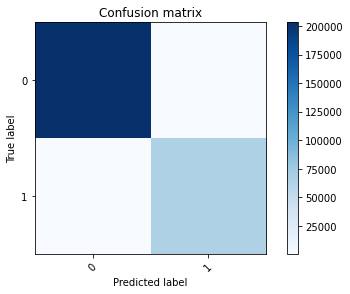
```
Confusion Matrix Values
[[203208     80]
 [   275  65185]]
 ```
 This above model's architecture is below. Note that this model used the Relu activaction function and the Adam optimizer and incorporated a dropout function.
 ```
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
dense_128 (Dense)            (None, 64)                7808      
_________________________________________________________________
dropout_29 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_129 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_130 (Dense)            (None, 2)                 66        
=================================================================
```



**Model 2** <br>
The second best model had an accuracy of 0.99859 and an average F1 score of 0.99859.
```
Classification Report from Keras
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    203288
           1       1.00      1.00      1.00     65460

    accuracy                           1.00    268748
   macro avg       1.00      1.00      1.00    268748
weighted avg       1.00      1.00      1.00    268748
```
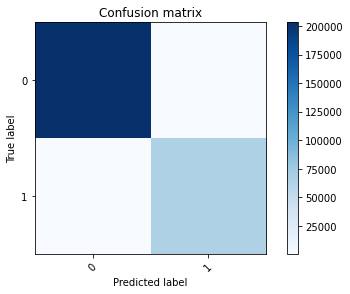
```
Confusion Matrix values
[[203185    103]
 [   277  65183]]
```
The above model's architecture is below. Note that this model used the Tanh activaction function and the SGD optimizer.

```
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
dense_113 (Dense)            (None, 16)                1952      
_________________________________________________________________
dense_114 (Dense)            (None, 8)                 136       
_________________________________________________________________
dense_115 (Dense)            (None, 4)                 36        
_________________________________________________________________
dense_116 (Dense)            (None, 2)                 10        
=================================================================
```




#### **Step 4:** Training a Fully Connected Neural Network with the Top Features Determined by Logistic Regression
Next we tried to extract the most important features using Logistic Regression. With this, we trained a model using only the top 30 features.

In [24]:
#New train/test split
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x, label_outcomes, test_size=0.25, random_state=42) 

In [25]:
#Create linear regression
regressor = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=.1)

#Fit/train linear regression
regressor.fit(x_train_reg,y_train_reg)

KeyboardInterrupt: ignored

In [26]:
#Show top features
names = list(data.columns.values)
names.remove("outcome")
report_coef(
  names,
  regressor.coef_[0])

IndexError: ignored

### **Training Result:**<br><br>
Below you can find the training results of the logistic regression model and the top features it picked out.

<img src="./lr 1.jpg"><br>
Coefficients<br><br>
<img src="./lr 2.jpg"><br>
Top 30 features<br><br>
<img src="./lr 3.jpg"><br>
MatPlotLib plot



In [27]:
#Create a new dataset using the top 30 features
top_30_data=data[['hot',
                 'service-IRC',
                 'is_guest_login',
                 'flag-REJ',
                 'wrong_fragment',
                 'service-smtp',
                 'service-private',
                 'service-http',
                 'srv_rerror_rate',
                 'flag-RSTR',
                 'flag-S0',
                 'service-urp_i',
                 'flag-S1',
                 'num_file_creations',
                 'service-pop_3',
                 'num_root',
                 'num_compromised',
                 'num_access_files',
                 'flag-RSTOS0',
                 'land',
                 'num_failed_logins',
                 'service-telnet',
                 'service-domain_u',
                 'service-ftp_data',
                 'root_shell',
                 'srv_serror_rate',
                 'service-auth',
                 'dst_bytes',
                 'service-nntp',
                 'urgent',
                 'outcome']].copy()


In [28]:
#Create new train/test split with top 30 features
outcome=encode_text_index(top_30_data,'outcome')

# Create x & y for training and testing
x, y = to_xy(top_30_data,'outcome')
    
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42) 

In [ ]:
#Train some models using only the top 30 features

#Model callbacks
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True)
i=1

#Build models
while (i<7):
  np.random.seed()
  seed=np.random.randint(1000000000)
  i+=1
  k=0

  #Train each model 5 times
  while (k<5):
    k+=1
    model = Sequential()
    model.add(Dense(32, input_dim=x.shape[1], activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    #Save the best weights
    if (k==1):
      model.save_weights('dnn/best_weights.hdf5')

    #Print model info and train
    print("=========== Model: "+str(i)+"."+str(k)+ " seed:"+str(seed)+" ===============")
    print(model.summary())
    model.fit(x_train,y_train, validation_data=(x_test,y_test),callbacks=[monitor, checkpointer],verbose=2,epochs=1000)
  
  #Check best score
  model.load_weights('dnn/best_weights.hdf5')

  #Measure accuracy and score
  pred = model.predict(x_test)
  pred = np.argmax(pred,axis=1)
  y_true = np.argmax(y_test,axis=1)
  score = metrics.accuracy_score(y_true, pred)

  #Save the model
  model.save('gs://project_2_reg/project 2/models/reg_'+str(score))
  print("model saved, Accuracy: ",score)

=========== Model: 2.1 seed:542624625 ===============
Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_134 (Dense)            (None, 32)                3904      
_________________________________________________________________
dropout_31 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_135 (Dense)            (None, 2)                 66        
Total params: 3,970
Trainable params: 3,970
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
25196/25196 - 27s - loss: 0.0116 - val_loss: 0.0073
Epoch 2/1000
25196/25196 - 25s - loss: 0.0074 - val_loss: 0.0063
Epoch 3/1000
25196/25196 - 25s - loss: 0.0067 - val_loss: 0.0058
Epoch 4/1000
25196/25196 - 25s - loss: 0.0064 - val_loss: 0.0060
Epoch 5/1000
25196/25196 - 25s - loss: 0.0061 - val_loss: 0.00

### **Training Results:** <br>
We were hoping that with less features this model would train faster. However, this was not the case. Rather each epoch was roughly the same speed (for humans) as the other fully connected models. Not only did it converge slower but it also did not get nearly as accurate (in relevant terms) as the other models. Overal, several models with different architectures were trained. <br><br>

 **Model 1** <br>
 This model had an accuracy of 0.98894 and an average F1 score of 0.98886
 ```
Classification Report from Keras
precision    recall  f1-score   support

           0       0.99      1.00      0.99    203288
           1       1.00      0.96      0.98     65460

    accuracy                           0.99    268748
   macro avg       0.99      0.98      0.98    268748
weighted avg       0.99      0.99      0.99    268748
 ```
 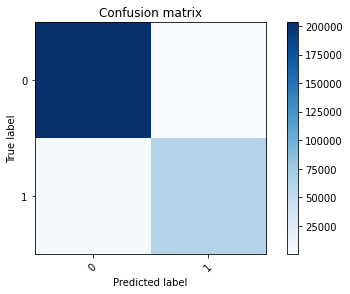
```
Confusion Matrix Values
[[203184    104]
 [  2869  62591]]
 ```
 The above model's architecture is below, Note that this model used the Tanh activaction function and the SGD optimizer and incorporated a drop out layer.
 ```
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
dense_66 (Dense)             (None, 16)                496       
_________________________________________________________________
dropout_11 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_67 (Dense)             (None, 4)                 68        
_________________________________________________________________
dense_68 (Dense)             (None, 2)                 10        
=================================================================
```



**Model 2** <br>
The second best model had an accuracy of 0.98893 and an average F1 score of 0.98885.
```
Classification Report from Keras
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    203288
           1       1.00      0.96      0.98     65460

    accuracy                           0.99    268748
   macro avg       0.99      0.98      0.98    268748
weighted avg       0.99      0.99      0.99    268748
```
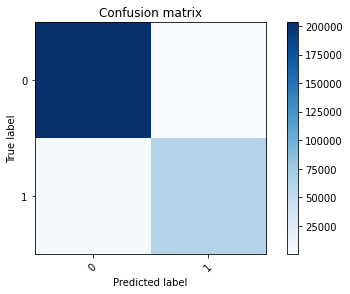
```
Confusion Matrix values
[[203188    100]
 [  2874  62586]]
```
The above model's architecture is below, Note that this model used the Relu activaction function and the SGD optimizer and incorporated a drop out layer.

```
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
dense_72 (Dense)             (None, 4)                 124       
_________________________________________________________________
dropout_14 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_73 (Dense)             (None, 2)                 10        
=================================================================
```


#### **Step 5:** Training a Deep Convolutional Neural Network
After finishing playing around with different techniques in the fully connected neural network world, we moved on to developing our CNN networks. The first step in doing so was reshaping our data correctly to feed it into a CNN model, the code for this is below. Once completed, we defined a series of CNN models to train. Some based off existing architectures and some that were simply tried. It was decided to explicitly write out each model rather than create a builder function due to the time it took to train each model.

In [ ]:
#Reshape the data
x_copy=x.copy()
x_copy = x_copy.reshape((x_copy.shape[0], 1, x_copy.shape[1], 1))
x_copy.shape

(1074992, 1, 121, 1)

In [ ]:
#Create a new train/test split
x_train, x_test, y_train, y_test = train_test_split(x_copy, y, test_size=0.25, random_state=42)

In [ ]:
#In this code block you can find the definitions for each CNN model created and tried.

#CNN model #1
def create_cnn_1():
  cnn = Sequential()
  cnn.add(Conv2D(64, kernel_size=(1, 3), strides=(1, 1), activation='relu', input_shape=(1, 121, 1)))
  cnn.add(MaxPooling2D(pool_size=(1,2)))
  cnn.add(Conv2D(128, kernel_size=(1, 3), strides=(1, 1), activation='relu'))
  cnn.add(MaxPooling2D(pool_size=(1,2)))     
  cnn.add(Flatten())
  cnn.add(Dense(1024, activation="relu"))
  cnn.add(Dropout(0.5))
  cnn.add(Dense(y_test.shape[1], activation="softmax"))

  #Define optimizer, compile, and return model
  cnn.compile(loss="categorical_crossentropy", optimizer="adam")
  return cnn

#CNN model #2
def create_cnn_2():
  cnn = Sequential()
  cnn.add(Conv2D(32, kernel_size=(1, 10), strides=(1, 1), activation='relu', input_shape=(1, 121, 1)))
  cnn.add(MaxPooling2D(pool_size=(1,5)))
  cnn.add(Conv2D(128, kernel_size=(1, 5), strides=(1, 1), activation='relu'))
  cnn.add(MaxPooling2D(pool_size=(1,2)))
  cnn.add(Conv2D(256, kernel_size=(1, 3), strides=(1, 1), activation='relu'))
  cnn.add(MaxPooling2D(pool_size=(1,2)))
  cnn.add(Flatten())
  cnn.add(Dense(1024, activation="relu"))
  cnn.add(Dropout(0.5))
  cnn.add(Dense(64, activation="relu"))
  cnn.add(Dense(y_test.shape[1], activation="softmax"))

  #Define optimizer, compile, and return model
  cnn.compile(loss="categorical_crossentropy", optimizer="sgd")
  return cnn

#CNN model #3
def create_cnn_3():
  cnn = Sequential()
  cnn.add(Conv2D(32, kernel_size=(1, 10), strides=(1, 1), activation='tanh', input_shape=(1, 121, 1)))
  cnn.add(Conv2D(128, kernel_size=(1, 5), strides=(1, 1), activation='tanh'))
  cnn.add(MaxPooling2D(pool_size=(1,3)))      
  cnn.add(Flatten())
  cnn.add(Dense(64, activation="tanh"))
  cnn.add(Dropout(0.1))
  cnn.add(Dense(4, activation="tanh"))
  cnn.add(Dense(y_test.shape[1], activation="softmax"))

  #Define optimizer, compile, and return model
  cnn.compile(loss="categorical_crossentropy", optimizer="sgd")
  return cnn

#CNN model #4
def create_cnn_4():
  cnn = Sequential()
  cnn.add(Conv2D(32, kernel_size=(1, 16), strides=(1, 1), activation='relu', input_shape=(1, 121, 1)))
  cnn.add(Conv2D(128, kernel_size=(1, 8), strides=(1, 1), activation='relu'))
  cnn.add(MaxPooling2D(pool_size=(1,4)))
  cnn.add(Conv2D(256, kernel_size=(1, 4), strides=(1, 1), activation='relu'))
  cnn.add(MaxPooling2D(pool_size=(1,2)))
  cnn.add(Conv2D(512, kernel_size=(1, 2), strides=(1, 1), activation='relu'))
  cnn.add(MaxPooling2D(pool_size=(1,2)))      
  cnn.add(Flatten())
  cnn.add(Dense(1024, activation="relu"))
  cnn.add(Dropout(0.1))
  cnn.add(Dense(64, activation="relu"))
  cnn.add(Dense(8, activation="relu"))
  cnn.add(Dense(y_test.shape[1], activation="softmax"))

  #Define the optimizer, compile, and return model
  cnn.compile(loss="categorical_crossentropy", optimizer="adam")
  return cnn

#CNN model #5
def create_cnn_5():
  cnn = Sequential()
  cnn.add(Conv2D(32, kernel_size=(1, 20), strides=(1, 1), activation='relu', input_shape=(1, 121, 1)))
  cnn.add(Conv2D(64, kernel_size=(1, 4), strides=(1, 1), activation='relu')) 
  cnn.add(MaxPooling2D(pool_size=(1,2)))
  cnn.add(Flatten())
  cnn.add(Dense(512, activation="relu"))
  cnn.add(Dropout(0.1))
  cnn.add(Dense(32, activation="relu"))
  cnn.add(Dropout(0.1))
  cnn.add(Dense(y_test.shape[1], activation="softmax"))

  #Define the optimizer, compile, and return model
  cnn.compile(loss="categorical_crossentropy", optimizer="adam")
  return cnn

#CNN model #6 - Based on the simple MNIST model
def create_cnn_6():
  cnn = Sequential()
  cnn.add(Conv2D(32, kernel_size=(1, 9), strides=(1, 1), activation='relu', input_shape=(1, 121, 1)))
  cnn.add(MaxPooling2D(pool_size=(1,4)))
  cnn.add(Conv2D(64, kernel_size=(1, 9), strides=(1, 1), activation='relu'))
  cnn.add(MaxPooling2D(pool_size=(1,4))) 
  cnn.add(Flatten())
  cnn.add(Dropout(0.5))
  cnn.add(Dense(y_test.shape[1], activation="softmax"))

  #Define the optimizer, compile, and return model
  cnn.compile(loss="categorical_crossentropy", optimizer="adam")
  return cnn

#CNN model #7
def create_cnn_7():
  cnn = Sequential()
  cnn.add(Conv2D(64, kernel_size=(1, 3), strides=(1, 1), activation='relu', input_shape=(1, 121, 1)))
  cnn.add(MaxPooling2D(pool_size=(1,2)))
  cnn.add(Conv2D(128, kernel_size=(1, 3), strides=(1, 1), activation='relu'))
  cnn.add(MaxPooling2D(pool_size=(1,2)))
  cnn.add(Conv2D(256, kernel_size=(1, 3), strides=(1, 1), activation='relu'))
  cnn.add(MaxPooling2D(pool_size=(1,2)))     
  cnn.add(Flatten())
  cnn.add(Dense(1024, activation="relu"))
  cnn.add(Dropout(0.5))
  cnn.add(Dense(y_test.shape[1], activation="softmax"))

  #Define the optmizer, compile, and return model
  cnn.compile(loss="categorical_crossentropy", optimizer="adam")
  return cnn

In [ ]:
#Model callbacks
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=4, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True)
cnn=None

#Run each model defined
for index in range(7):
  start_time = time.time()
  if (index==0):
    cnn=create_cnn_1()
  elif (index==1):
    cnn=create_cnn_2()
  elif (index==2):
    cnn=create_cnn_3()
  elif (index==3):
    cnn=create_cnn_4()
  elif (index==4):
    cnn=create_cnn_5()
  elif (index==5):
    cnn=create_cnn_6()
  elif (index==6):
    cnn=create_cnn_7()

  #Save the weights
  cnn.save_weights('dnn/best_weights.hdf5')

  #Train the model
  cnn.fit(x_train, y_train,     
            batch_size=32,
            epochs=1000,
            verbose=2,
            validation_data=(x_test, y_test),
          callbacks=[monitor, checkpointer])

  #Print elapsed time, score the model, and save it.
  elapsed_time = time.time() - start_time
  print("Elapsed time: {}".format(hms_string(elapsed_time)))
  cnn.load_weights('dnn/best_weights.hdf5')
  score = cnn.evaluate(x_test, y_test, verbose=0)
  cnn.save('gs://project_2_reg/project 2/models/cnn_'+str(score)) 

Epoch 1/1000
25196/25196 - 232s - loss: 0.0101 - val_loss: 0.0094
Epoch 2/1000
25196/25196 - 231s - loss: 0.0064 - val_loss: 0.0045
Epoch 3/1000
25196/25196 - 231s - loss: 0.0055 - val_loss: 0.0042
Epoch 4/1000
25196/25196 - 231s - loss: 0.0044 - val_loss: 0.0030
Epoch 5/1000
25196/25196 - 229s - loss: 0.0038 - val_loss: 0.0040
Epoch 6/1000
25196/25196 - 232s - loss: 0.0035 - val_loss: 0.0029
Epoch 7/1000
25196/25196 - 230s - loss: 0.0031 - val_loss: 0.0024
Epoch 8/1000
25196/25196 - 229s - loss: 0.0031 - val_loss: 0.0023
Epoch 9/1000
25196/25196 - 230s - loss: 0.0031 - val_loss: 0.0024
Epoch 10/1000
25196/25196 - 231s - loss: 0.0032 - val_loss: 0.0023
Epoch 11/1000
25196/25196 - 231s - loss: 0.0033 - val_loss: 0.0024
Epoch 12/1000
25196/25196 - 233s - loss: 0.0031 - val_loss: 0.0028
Epoch 13/1000
25196/25196 - 229s - loss: 0.0032 - val_loss: 0.0027
Epoch 14/1000
25196/25196 - 231s - loss: 0.0032 - val_loss: 0.0024
Epoch 00014: early stopping
Elapsed time: 0:53:58.18
INFO:tensorflow:As

INFO:tensorflow:Assets written to: gs://project_2_reg/project 2/models/cnn_0.002298494568094611/assets


Epoch 1/1000
25196/25196 - 199s - loss: 0.0219 - val_loss: 0.0113
Epoch 2/1000
25196/25196 - 198s - loss: 0.0101 - val_loss: 0.0079
Epoch 3/1000
25196/25196 - 198s - loss: 0.0077 - val_loss: 0.0064
Epoch 4/1000
25196/25196 - 199s - loss: 0.0067 - val_loss: 0.0061
Epoch 5/1000
25196/25196 - 199s - loss: 0.0060 - val_loss: 0.0061
Epoch 6/1000
25196/25196 - 198s - loss: 0.0056 - val_loss: 0.0061
Epoch 7/1000
25196/25196 - 199s - loss: 0.0052 - val_loss: 0.0044
Epoch 8/1000
25196/25196 - 199s - loss: 0.0049 - val_loss: 0.0043
Epoch 9/1000
25196/25196 - 198s - loss: 0.0046 - val_loss: 0.0038
Epoch 10/1000
25196/25196 - 199s - loss: 0.0043 - val_loss: 0.0047
Epoch 11/1000
25196/25196 - 199s - loss: 0.0042 - val_loss: 0.0036
Epoch 12/1000
25196/25196 - 198s - loss: 0.0040 - val_loss: 0.0039
Epoch 13/1000
25196/25196 - 199s - loss: 0.0038 - val_loss: 0.0031
Epoch 14/1000
25196/25196 - 198s - loss: 0.0037 - val_loss: 0.0039
Epoch 15/1000
25196/25196 - 198s - loss: 0.0035 - val_loss: 0.0034
Epoc

INFO:tensorflow:Assets written to: gs://project_2_reg/project 2/models/cnn_0.6541714668273926/assets


Epoch 1/1000
25196/25196 - 122s - loss: 0.0188 - val_loss: 0.0133
Epoch 2/1000
25196/25196 - 144s - loss: 0.0127 - val_loss: 0.0115
Epoch 3/1000
25196/25196 - 137s - loss: 0.0111 - val_loss: 0.0102
Epoch 4/1000
25196/25196 - 124s - loss: 0.0095 - val_loss: 0.0086
Epoch 5/1000
25196/25196 - 127s - loss: 0.0083 - val_loss: 0.0076
Epoch 6/1000
25196/25196 - 124s - loss: 0.0075 - val_loss: 0.0068
Epoch 7/1000
25196/25196 - 131s - loss: 0.0069 - val_loss: 0.0063
Epoch 8/1000
25196/25196 - 133s - loss: 0.0065 - val_loss: 0.0063
Epoch 9/1000
25196/25196 - 132s - loss: 0.0061 - val_loss: 0.0054
Epoch 10/1000
25196/25196 - 141s - loss: 0.0058 - val_loss: 0.0051
Epoch 11/1000
25196/25196 - 131s - loss: 0.0055 - val_loss: 0.0050
Epoch 12/1000
25196/25196 - 132s - loss: 0.0053 - val_loss: 0.0048
Epoch 13/1000
25196/25196 - 122s - loss: 0.0052 - val_loss: 0.0048
Epoch 14/1000
25196/25196 - 130s - loss: 0.0050 - val_loss: 0.0044
Epoch 15/1000
25196/25196 - 146s - loss: 0.0049 - val_loss: 0.0052
Epoc

INFO:tensorflow:Assets written to: gs://project_2_reg/project 2/models/cnn_0.001982341054826975/assets


Epoch 1/1000
25196/25196 - 384s - loss: 0.0144 - val_loss: 0.0095
Epoch 2/1000
25196/25196 - 381s - loss: 0.0079 - val_loss: 0.0057
Epoch 3/1000
25196/25196 - 384s - loss: 0.0072 - val_loss: 0.0062
Epoch 4/1000
25196/25196 - 383s - loss: 0.0063 - val_loss: 0.0050
Epoch 5/1000
25196/25196 - 384s - loss: 0.0058 - val_loss: 0.0050
Epoch 6/1000
25196/25196 - 380s - loss: 0.0063 - val_loss: 0.0081
Epoch 7/1000
25196/25196 - 384s - loss: 0.0065 - val_loss: 0.0065
Epoch 8/1000
25196/25196 - 385s - loss: 0.0084 - val_loss: 0.0079
Epoch 9/1000
25196/25196 - 386s - loss: 0.0095 - val_loss: 0.0125
Epoch 00009: early stopping
Elapsed time: 0:57:34.12
INFO:tensorflow:Assets written to: gs://project_2_reg/project 2/models/cnn_0.6989647746086121/assets


INFO:tensorflow:Assets written to: gs://project_2_reg/project 2/models/cnn_0.6989647746086121/assets


Epoch 1/1000
25196/25196 - 172s - loss: 0.0096 - val_loss: 0.0062
Epoch 2/1000
25196/25196 - 185s - loss: 0.0066 - val_loss: 0.0054
Epoch 3/1000
25196/25196 - 183s - loss: 0.0057 - val_loss: 0.0063
Epoch 4/1000
25196/25196 - 182s - loss: 0.0051 - val_loss: 0.0061
Epoch 5/1000
25196/25196 - 190s - loss: 0.0048 - val_loss: 0.0042
Epoch 6/1000
25196/25196 - 196s - loss: 0.0046 - val_loss: 0.0069
Epoch 7/1000
25196/25196 - 201s - loss: 0.0046 - val_loss: 0.0058
Epoch 8/1000
25196/25196 - 194s - loss: 0.0046 - val_loss: 0.0043
Epoch 9/1000
25196/25196 - 180s - loss: 0.0046 - val_loss: 0.0046
Epoch 00009: early stopping
Elapsed time: 0:28:08.33
INFO:tensorflow:Assets written to: gs://project_2_reg/project 2/models/cnn_0.6984068751335144/assets


INFO:tensorflow:Assets written to: gs://project_2_reg/project 2/models/cnn_0.6984068751335144/assets


Epoch 1/1000
25196/25196 - 89s - loss: 0.0126 - val_loss: 0.0068
Epoch 2/1000
25196/25196 - 86s - loss: 0.0079 - val_loss: 0.0058
Epoch 3/1000
25196/25196 - 87s - loss: 0.0071 - val_loss: 0.0052
Epoch 4/1000
25196/25196 - 87s - loss: 0.0067 - val_loss: 0.0052
Epoch 5/1000
25196/25196 - 86s - loss: 0.0064 - val_loss: 0.0048
Epoch 6/1000
25196/25196 - 87s - loss: 0.0063 - val_loss: 0.0047
Epoch 7/1000
25196/25196 - 86s - loss: 0.0061 - val_loss: 0.0050
Epoch 8/1000
25196/25196 - 85s - loss: 0.0059 - val_loss: 0.0047
Epoch 9/1000
25196/25196 - 87s - loss: 0.0058 - val_loss: 0.0046
Epoch 10/1000
25196/25196 - 86s - loss: 0.0057 - val_loss: 0.0051
Epoch 11/1000
25196/25196 - 85s - loss: 0.0056 - val_loss: 0.0058
Epoch 12/1000
25196/25196 - 86s - loss: 0.0059 - val_loss: 0.0051
Epoch 13/1000
25196/25196 - 86s - loss: 0.0057 - val_loss: 0.0043
Epoch 14/1000
25196/25196 - 85s - loss: 0.0056 - val_loss: 0.0041
Epoch 15/1000
25196/25196 - 86s - loss: 0.0056 - val_loss: 0.0042
Epoch 16/1000
25196

INFO:tensorflow:Assets written to: gs://project_2_reg/project 2/models/cnn_0.6220740079879761/assets


### **Training Results:** <br>
The CNN models took the longest to train but ended up producing the best results. We did not believe the CNN models would outperform our standard fully connected neural networks, but were suprised to see that as the case as they performed slightly better. Several models with different architectures were ran. <br><br>

 **Model 1** <br>
 This model had an accuracy of 0.99961 and an average F1 score of 0.99961.
 ```
  precision    recall  f1-score   support

           0       1.00      1.00      1.00    203288
           1       1.00      1.00      1.00     65460

    accuracy                           1.00    268748
   macro avg       1.00      1.00      1.00    268748
weighted avg       1.00      1.00      1.00    268748
 ```
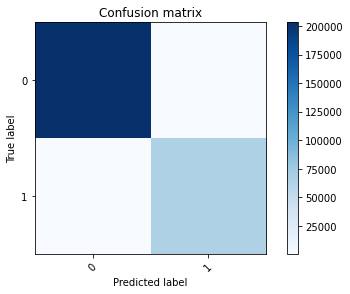
```
Confusion Matrix Values
[[203255     33]
 [    73  65387]]
 ```
 This above model's architecture is below. This model was created using the create_cnn_3() function. Note that this model used the Relu activaction function and the Adam optimizer
 ```
 _________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d_31 (Conv2D)           (None, 1, 119, 64)        256       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 1, 59, 64)         0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 1, 57, 128)        24704     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 1, 28, 128)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 1, 26, 256)        98560     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 1, 13, 256)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 3328)              0         
_________________________________________________________________
dense_105 (Dense)            (None, 1024)              3408896   
_________________________________________________________________
dropout_28 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_106 (Dense)            (None, 2)                 2050      
=================================================================
```



**Model 2** <br>
The second best model had an accuracy of 0.99948 and a average F1 score of 0.99948.
```
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    203288
           1       1.00      1.00      1.00     65460
    accuracy                           1.00    268748
   macro avg       1.00      1.00      1.00    268748
weighted avg       1.00      1.00      1.00    268748
```
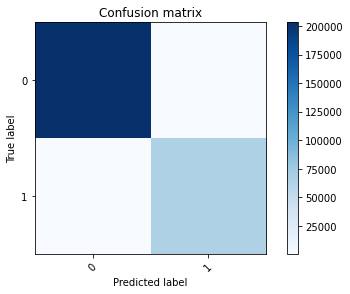
```
Confusion Matrix values
[[203221     67]
 [    72  65388]]
```
The above model's architecture is below. This model was created using the create_cnn_7() function. Note that this model used the Tanh activaction function and the SGD optimizer.

```
_________________________________________________________________
Layer (type)                 Output Shape              Param number   
=================================================================
conv2d_18 (Conv2D)           (None, 1, 112, 32)        352       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 1, 108, 128)       20608     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 1, 36, 128)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_92 (Dense)             (None, 64)                294976    
_________________________________________________________________
dropout_22 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_93 (Dense)             (None, 4)                 260       
_________________________________________________________________
dense_94 (Dense)             (None, 2)                 10        
=================================================================
Total params: 316,206
Trainable params: 316,206
Non-trainable params: 0
```

